Can one use regression to associate CREs with gene expression?

we will try to answer this question by using linear (lasso) regression to predict gene expression based on accessibility of linked promoter and enhancers (CREs) by linking ATAC peaks to genes via their proximity to the TSS 

here we are plotting an R^2 barplot. Here a high R^2(exlained variance) shows a strong lnk betwenn CREs and gene expression to shows whic CREs play a larger role here. and show us if accessible CREs containe nough information in order to predict gene expression

also we will show a coefficient plot which illustrates whether individual CREs act repressing(negative value) or activating (positive value)

lastly a histogramm showing the distribuiton of r^2 throughout different genes will show how much of the variance of gene expression can be explained for each gene with this approach. 

In [14]:
#test 
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

ATAC = data['ATAC_seq']
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']

def get_tss(row):
    # Use the correct column names from Exons
    if row["Strand"] == "+":
        return row["Transcription Start"]
    else:
        return row["Transcription End"]  # or another column if appropriate

Exons["TSS"] = Exons.apply(get_tss, axis=1)

linked_data = []
for _, gene_row in Exons.iterrows():
    gene_name = gene_row["Genname"]
    chrom = gene_row["Chromosom"]
    tss = gene_row["TSS"]

    
    nearby_peaks = ATAC[
        (ATAC["chrom"] == chrom) &
        (np.abs(ATAC["Summit"] - tss) <= 100_000)
    ]

    for _, peak_row in nearby_peaks.iterrows():
        linked_data.append({
            "GeneName": gene_name,
            "PeakID": peak_row.name,
            "DistanceToTSS": np.abs(peak_row["Summit"] - tss)
        })

link_df = pd.DataFrame(linked_data)


In [ ]:
#lasso regression
results = []
coefs = {}

for gene in RNA.index:
    gene_links = link_df[link_df["GeneName"] == gene]
    if gene_links.empty:
        continue
    
# Peaks for this gene
    peaks = gene_links["PeakID"].astype(str).unique()
    atac_subset = ATAC.loc[ATAC.index.isin(peaks)]
    shared_samples = [col for col in RNA.columns if col in atac_subset.columns]
    atac_matrix = atac_subset[shared_samples].transpose().fillna(0).values
    y = RNA.loc[gene, shared_samples].values
    
    if atac_matrix.shape[1] == 0 or np.linalg.matrix_rank(atac_matrix) < 2:
        continue

    model = LassoCV(cv=3).fit(atac_matrix, y)
    y_pred = model.predict(atac_matrix)
    r2 = r2_score(y, y_pred)

    results.append({
        "Gene": gene,
        "R2": r2,
        "Num_CRs": atac_matrix.shape[1]
    })

    coefs[gene] = pd.Series(model.coef_, index=peaks)

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)

# R² values (explain variance)
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(8, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

results_df.sort_values("R2", ascending=False)


c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.508e-03, tolerance: 2.547e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.651e-03, tolerance: 2.547e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

now we will show how much of the variance of gene expression can be explained for each gene with this approach. By showing the distribution of R^2 across genes.

now will will look at how the coefficients differ when this analysis is performed on only abT and gdT cells?
This asks:

How does the importance of each in predicting gene expression change when we restrict analysis to only our specific lineage instaead of to using all samples?

In [10]:
#subset ab and gd t cells
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)


print("Available keys in data:", list(data.keys()))
atac_abgd = data['list_ATAC_diff_Tc_ab_gd']
if atac_abgd is None:
    print("Key 'list_ATAC_diff_Tc_ab_gd' not found in data.")
else:
    print(atac_abgd)

ab_gd= data['ab_gd_tc']
rna_abgd = RNA[ab_gd]


from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

abgd_results = []

for gene, group in peaks.groupby("GeneName"):
    y = rna_abgd.loc[gene].values

    peak_ids = group["PeakID"].values
    x = atac_abgd.loc[peak_ids].T.values  # shape: (samples, peaks)

    if x.shape[1] < 2:  # skip genes with fewer than 2 CREs
        continue

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    model_lineage = LassoCV(cv=5).fit(x_scaled, y)

    abgd_results.append({
        "GeneName": gene,
        "PeakIDs": peak_ids,
        "LineageCoefs": model_lineage.coef_
    })

comparison = []

for lineage in abgd_results:
    gene = lineage["GeneName"]
    peak_ids = lineage["PeakIDs"]

    # Match to full model entry
    full = next((f for f in results_df if f["GeneName"] == gene and all(f["PeakIDs"] == peak_ids)), None)
    if full is None:
        continue

    diff = full["FullCoefs"] - lineage["LineageCoefs"]

    for i, peak in enumerate(peak_ids):
        comparison.append({
            "GeneName": gene,
            "PeakID": peak,
            "FullCoef": full["FullCoefs"][i],
            "LineageCoef": lineage["LineageCoefs"][i],
            "Difference": diff[i]
        })
        
import matplotlib.pyplot as plt
import pandas as pd

comp_df = pd.DataFrame(comparison)

plt.figure(figsize=(6, 6))
plt.scatter(comp_df["FullCoef"], comp_df["LineageCoef"], alpha=0.5)
plt.plot([-1, 1], [-1, 1], linestyle="--", color="gray")  # identity line
plt.xlabel("Full Model Coefficient")
plt.ylabel("Lineage Model Coefficient")
plt.title("CRE Coefficient Shift: Full vs Lineage Model")
plt.grid(True)
plt.tight_layout()
plt.show()


import seaborn as sns

pivot = comp_df.pivot(index="GeneName", columns="PeakID", values="Difference")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.fillna(0), cmap="coolwarm", center=0)
plt.title("Coefficient Differences (Full - Lineage)")
plt.xlabel("CRE (Peak)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()



Available keys in data: ['ATAC_seq', 'ATAC_seq_T', 'ATAC_seq_scores_no_norm', 'norm_scores', 'RNA_seq', 'RNA_seq_T', 'QC_metrics', 'exons', 'list_ATAC_stem_Tc_Bc', 'list_ATAC_diff_Tc_all', 'list_ATAC_diff_Tc_pre_ab_act', 'list_ATAC_diff_Tc_gd', 'list_ATAC_diff_Tc_ab', 'list_ATAC_diff_Tc_ab_gd', 'list_ATAC_Tc_all', 'test1', 'ab_tc', 'gd_tc', 'ab_gd_tc']
['preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'NKT.Sp', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp']


NameError: name 'peaks' is not defined

Interpretation
Points far from diagonal in the scatterplot = CREs whose importance changes between full and lineage models.

Positive differences: CRE is stronger in full model than in lineage (possibly due to other lineages).

Negative differences: CRE is stronger in lineage (lineage-specific regulation).

Heatmap: identifies which CREs are lineage-specific regulators.

now we will analize which CREs are active in ab_tc & gd_tc cell lineages, by ranking different CREs absolute regression coefficients in a CRE-bipartile network graph a CRE importance heatmap and a barplot of top CREs for our specific lineage whereas CREs at the top of the barplot are likely to drive expression of lineage-specific genes. 

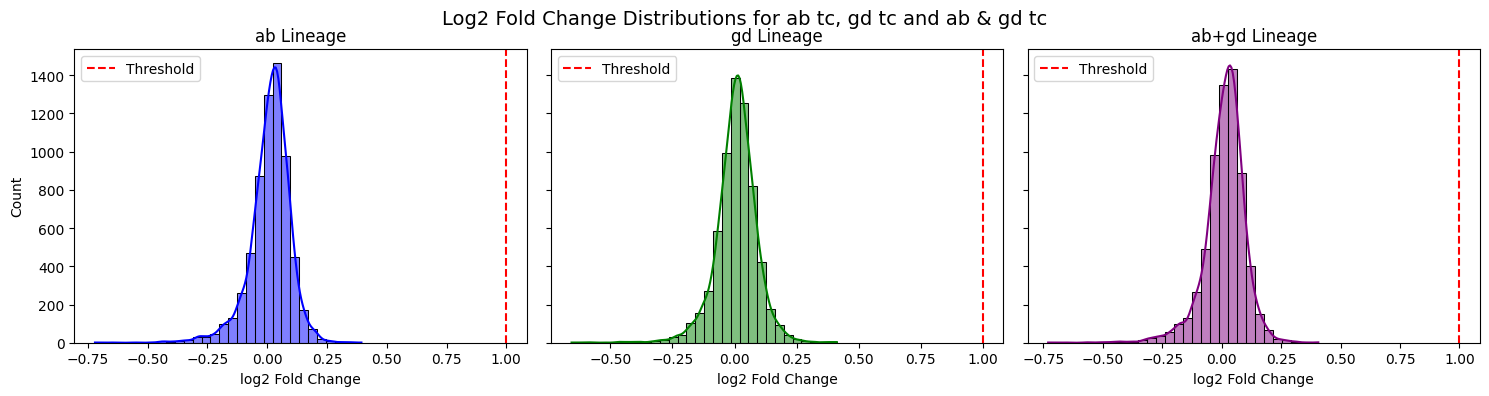

NameError: name 'results_df' is not defined

<Figure size 1000x500 with 0 Axes>

In [11]:
ab_gd= data['ab_gd_tc']
ab= data['ab_tc']
gd= data['gd_tc']
other_cols_ab = [col for col in RNA.columns if col not in ab]
other_cols_gd = [col for col in RNA.columns if col not in gd]
other_cols_ab_gd = [col for col in RNA.columns if col not in ab_gd]

#cre expression in abgd vs not
mean_expr_ab_gd = RNA[ab_gd].mean(axis=1)
mean_expr_ab = RNA[ab].mean(axis=1)
mean_expr_gd = RNA[gd].mean(axis=1)

mean_expr_other_ab = RNA[other_cols_ab].mean(axis=1)
mean_expr_other_gd = RNA[other_cols_gd].mean(axis=1)
mean_expr_others_ab_gd = RNA[other_cols_ab_gd].mean(axis=1)

#log fold change
log_fc_abgd = np.log2((mean_expr_ab_gd + 1e-3) / (mean_expr_others_ab_gd + 1e-3))
abgd_specific_genes = log_fc_abgd[log_fc_abgd > 1.0].index  # Log2FC > 1 = highly lineage-specific

log_fc_ab = np.log2((mean_expr_ab + 1e-3) / (mean_expr_other_ab + 1e-3))
ab_specific_genes = log_fc_ab[log_fc_ab > 1.0].index

log_fc_gd = np.log2((mean_expr_gd + 1e-3) / (mean_expr_other_gd + 1e-3))
gd_specific_genes = log_fc_gd[log_fc_gd > 1.0].index

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

sns.histplot(log_fc_ab, bins=30, kde=True, ax=axs[0], color='blue')
axs[0].axvline(1.0, color='red', linestyle='--', label='Threshold')
axs[0].set_title("ab Lineage")
axs[0].set_xlabel("log2 Fold Change")
axs[0].legend()

sns.histplot(log_fc_gd, bins=30, kde=True, ax=axs[1], color='green')
axs[1].axvline(1.0, color='red', linestyle='--', label='Threshold')
axs[1].set_title("gd Lineage")
axs[1].set_xlabel("log2 Fold Change")
axs[1].legend()

sns.histplot(log_fc_abgd, bins=30, kde=True, ax=axs[2], color='purple')
axs[2].axvline(1.0, color='red', linestyle='--', label='Threshold')
axs[2].set_title("ab+gd Lineage")
axs[2].set_xlabel("log2 Fold Change")
axs[2].legend()

plt.suptitle("Log2 Fold Change Distributions for ab tc, gd tc and ab & gd tc", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # leave space for suptitle
plt.show()

# ab gd tc specific genes, modeled in Lasso
abgd_genes_modeled = [g for g in abgd_specific_genes if g in coefs]
ab_genes_modeled = [g for g in ab_specific_genes if g in coefs]
gd_genes_modeled = [g for g in gd_specific_genes if g in coefs] 

from collections import defaultdict

cre_impact_abgd = defaultdict(float)
for gene in abgd_genes_modeled:
    coef_series = coefs[gene]
    for cre, val in coef_series.items():
        cre_impact_abgd[cre] += np.abs(val)  #
cre_impact_series_abgd = pd.Series(cre_impact_abgd).sort_values(ascending=False)

cre_impact_ab = defaultdict(float)
for gene in ab_genes_modeled:
    coef_series = coefs[gene]
    for cre, val in coef_series.items():
        cre_impact_ab[cre] += np.abs(val)  #
cre_impact_series_ab = pd.Series(cre_impact_ab).sort_values(ascending=False)

cre_impact_gd = defaultdict(float)
for gene in gd_genes_modeled:
    coef_series = coefs[gene]
    for cre, val in coef_series.items():
        cre_impact_gd[cre] += np.abs(val)  #
cre_impact_series_gd = pd.Series(cre_impact_gd).sort_values(ascending=False)

# R² scores
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#top gene effect plot
top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(8, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

# histogram explained variance (R²)
plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# plots of logFCs
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
sns.histplot(log_fc_abgd, bins=30, kde=True, ax=axs[0], color='purple')
axs[0].axvline(1.0, color='red', linestyle='--')
axs[0].set_title("log2FC ab+gd")
axs[0].set_xlabel("log2(Expr/Other)")

sns.histplot(log_fc_ab, bins=30, kde=True, ax=axs[1], color='blue')
axs[1].axvline(1.0, color='red', linestyle='--')
axs[1].set_title("log2FC ab")
axs[1].set_xlabel("log2(Expr/Other)")

sns.histplot(log_fc_gd, bins=30, kde=True, ax=axs[2], color='green')
axs[2].axvline(1.0, color='red', linestyle='--')
axs[2].set_title("log2FC gd")
axs[2].set_xlabel("log2(Expr/Other)")

plt.tight_layout()
plt.show()

#top 20 ab, gd, and abgd tc CREs
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

cre_impact_series_ab.head(20).plot(
    kind='bar', color='blue', ax=axs[0]
)
axs[0].set_title("Top CREs for ab Genes")
axs[0].set_xlabel("CRE")
axs[0].tick_params(axis='x', rotation=90)

cre_impact_series_gd.head(20).plot(
    kind='bar', color='green', ax=axs[1]
)
axs[1].set_title("Top CREs for gd Genes")
axs[1].set_xlabel("CRE")
axs[1].tick_params(axis='x', rotation=90)

cre_impact_series_abgd.head(20).plot(
    kind='bar', color='purple', ax=axs[2]
)
axs[2].set_title("Top CREs for ab+gd Genes")
axs[2].set_ylabel("Cumulative |Coefficient|")
axs[2].set_xlabel("CRE")
axs[2].tick_params(axis='x', rotation=90)

plt.suptitle("Top CREs regulating ab/gd Tcells", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  
plt.show()



In [ ]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict

ATAC = data['ATAC_seq']
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']

# Define lineage groups
list_ATAC_diff_Tc_ab = (
    list(ATAC.loc[:, 'preT.DN1.Th':'T.4.Nve.Fem.Sp']) +
    list(ATAC.loc[:, 'Treg.4.FP3+.Nrplo.Co':'T.8.Nve.Sp']) +
    ['NKT.Sp']
)
list_ATAC_diff_Tc_gd = list(ATAC.loc[:, 'gd.T1a.Th':'gd.T4.Fem.Sp'])
list_ATAC_diff_Tc_ab_gd = list_ATAC_diff_Tc_ab + list_ATAC_diff_Tc_gd

# Mean RNA expression per lineage
mean_expr_ab = RNA[list_ATAC_diff_Tc_ab].mean(axis=1)
mean_expr_gd = RNA[list_ATAC_diff_Tc_gd].mean(axis=1)
mean_expr_ab_gd = RNA[list_ATAC_diff_Tc_ab_gd].mean(axis=1)

mean_expr_other_ab = RNA.drop(columns=list_ATAC_diff_Tc_ab).mean(axis=1)
mean_expr_other_gd = RNA.drop(columns=list_ATAC_diff_Tc_gd).mean(axis=1)
mean_expr_others_ab_gd = RNA.drop(columns=list_ATAC_diff_Tc_ab_gd).mean(axis=1)

# Log fold change
log_fc_abgd = np.log2((mean_expr_ab_gd + 1e-3) / (mean_expr_others_ab_gd + 1e-3))
abgd_specific_genes = log_fc_abgd[log_fc_abgd > 1.0].index

log_fc_ab = np.log2((mean_expr_ab + 1e-3) / (mean_expr_other_ab + 1e-3))
ab_specific_genes = log_fc_ab[log_fc_ab > 1.0].index

log_fc_gd = np.log2((mean_expr_gd + 1e-3) / (mean_expr_other_gd + 1e-3))
gd_specific_genes = log_fc_gd[log_fc_gd > 1.0].index

# Compute TSS
def get_tss(row):
    if row["Strand"] == "+":
        return row["Transcription Start"]
    else:
        return row["Transcription Start"]

Exons["TSS"] = Exons.apply(get_tss, axis=1)

# Match genes to nearby CREs
linked_data = []
for _, gene_row in Exons.iterrows():
    gene_name = gene_row["Genname"]
    chrom = gene_row["Chromosom"]
    tss = gene_row["TSS"]

    nearby_peaks = ATAC[
        (ATAC["chrom"] == chrom) &
        (np.abs(ATAC["Summit"] - tss) <= 100_000)
    ]

    for _, peak_row in nearby_peaks.iterrows():
        linked_data.append({
            "GeneName": gene_name,
            "PeakID": peak_row.name,
            "DistanceToTSS": np.abs(peak_row["Summit"] - tss)
        })

link_df = pd.DataFrame(linked_data)

# Lasso regression
results = []
coefs = {}

for gene in RNA.index:
    gene_links = link_df[link_df["GeneName"] == gene]
    if gene_links.empty:
        continue

    peaks = gene_links["PeakID"].astype(str).unique()
    atac_subset = ATAC.loc[ATAC.index.isin(peaks)]
    atac_matrix = atac_subset[RNA.columns].transpose().fillna(0).values
    y = RNA.loc[gene].values

    if atac_matrix.shape[1] == 0:
        continue

    model = LassoCV(cv=3).fit(atac_matrix, y)
    y_pred = model.predict(atac_matrix)
    r2 = r2_score(y, y_pred)

    results.append({
        "Gene": gene,
        "R2": r2,
        "Num_CRs": atac_matrix.shape[1]
    })

    coefs[gene] = pd.Series(model.coef_, index=peaks)

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)

# Lineage-specific genes modeled
abgd_genes_modeled = [g for g in abgd_specific_genes if g in coefs]
ab_genes_modeled = [g for g in ab_specific_genes if g in coefs]
gd_genes_modeled = [g for g in gd_specific_genes if g in coefs]

# Calculate CRE impact
cre_impact_abgd = defaultdict(float)
for gene in abgd_genes_modeled:
    for cre, val in coefs[gene].items():
        cre_impact_abgd[cre] += np.abs(val)
cre_impact_series_abgd = pd.Series(cre_impact_abgd).sort_values(ascending=False)

cre_impact_ab = defaultdict(float)
for gene in ab_genes_modeled:
    for cre, val in coefs[gene].items():
        cre_impact_ab[cre] += np.abs(val)
cre_impact_series_ab = pd.Series(cre_impact_ab).sort_values(ascending=False)

cre_impact_gd = defaultdict(float)
for gene in gd_genes_modeled:
    for cre, val in coefs[gene].items():
        cre_impact_gd[cre] += np.abs(val)
cre_impact_series_gd = pd.Series(cre_impact_gd).sort_values(ascending=False)

# Plot R² scores
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top gene effect plot
top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(8, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

# Histogram of explained variance
plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# Visualize logFCs
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
sns.histplot(log_fc_abgd, bins=30, kde=True, ax=axs[0], color='purple')
axs[0].axvline(1.0, color='red', linestyle='--')
axs[0].set_title("log2FC ab+gd")
axs[0].set_xlabel("log2(Expr/Other)")

sns.histplot(log_fc_ab, bins=30, kde=True, ax=axs[1], color='blue')
axs[1].axvline(1.0, color='red', linestyle='--')
axs[1].set_title("log2FC ab")
axs[1].set_xlabel("log2(Expr/Other)")

sns.histplot(log_fc_gd, bins=30, kde=True, ax=axs[2], color='green')
axs[2].axvline(1.0, color='red', linestyle='--')
axs[2].set_title("log2FC gd")
axs[2].set_xlabel("log2(Expr/Other)")

plt.tight_layout()
plt.show()

# Visualize top CREs per lineage
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
cre_impact_series_abgd.head(20).plot(kind='bar', ax=axs[0], color='purple')
axs[0].set_title("Top CREs Regulating ab+gd Genes")
axs[0].set_ylabel("Cumulative |Coefficient|")
axs[0].set_xlabel("CRE")
axs[0].tick_params(axis='x', rotation=90)

cre_impact_series_ab.head(20).plot(kind='bar', ax=axs[1], color='blue')
axs[1].set_title("Top CREs Regulating ab Genes")
axs[1].set_xlabel("CRE")
axs[1].tick_params(axis='x', rotation=90)

cre_impact_series_gd.head(20).plot(kind='bar', ax=axs[2], color='green')
axs[2].set_title("Top CREs Regulating gd Genes")
axs[2].set_xlabel("CRE")
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
